# Uni-Mol Molecular Property Prediction


**Licenses**

Copyright (c) DP Technology.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.

**Citations**

Please cite the following papers if you use this notebook:

- Gengmo Zhou, Zhifeng Gao, Qiankun Ding, Hang Zheng, Hongteng Xu, Zhewei Wei, Linfeng Zhang, Guolin Ke. "[Uni-Mol: A Universal 3D Molecular Representation Learning Framework.](https://chemrxiv.org/engage/chemrxiv/article-details/6318b529bada388485bc8361)"
  ChemRxiv (2022)


## Data Preparation (SMILES, label to .lmdb)


In [1]:
import os
import lmdb
import pickle
import time
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from multiprocessing import Pool
from rdkit.Chem import AllChem
from rdkit import RDLogger

from utils import relaxed_spearman_correlation

RDLogger.DisableLog("rdApp.*")
import warnings

warnings.filterwarnings(action="ignore")

# def smi2_2Dcoords(smi):
#     mol = Chem.MolFromSmiles(smi)
#     mol = AllChem.AddHs(mol)
#     AllChem.Compute2DCoords(mol)
#     coordinates = mol.GetConformer().GetPositions().astype(np.float32)
#     len(mol.GetAtoms()) == len(coordinates), "2D coordinates shape is not align with {}".format(smi)
#     return coordinates


# def smi2_3Dcoords(smi,cnt):
#     mol = Chem.MolFromSmiles(smi)
#     mol = AllChem.AddHs(mol)
#     coordinate_list=[]
#     for seed in range(cnt):
#         try:
#             res = AllChem.EmbedMolecule(mol, randomSeed=seed)  # will random generate conformer with seed equal to -1. else fixed random seed.
#             if res == 0:
#                 try:
#                     AllChem.MMFFOptimizeMolecule(mol)       # some conformer can not use MMFF optimize
#                     coordinates = mol.GetConformer().GetPositions()
#                 except:
#                     print("Failed to generate 3D, replace with 2D")
#                     coordinates = smi2_2Dcoords(smi)

#             elif res == -1:
#                 mol_tmp = Chem.MolFromSmiles(smi)
#                 AllChem.EmbedMolecule(mol_tmp, maxAttempts=5000, randomSeed=seed)
#                 mol_tmp = AllChem.AddHs(mol_tmp, addCoords=True)
#                 try:
#                     AllChem.MMFFOptimizeMolecule(mol_tmp)       # some conformer can not use MMFF optimize
#                     coordinates = mol_tmp.GetConformer().GetPositions()
#                 except:
#                     print("Failed to generate 3D, replace with 2D")
#                     coordinates = smi2_2Dcoords(smi)
#         except:
#             print("Failed to generate 3D, replace with 2D")
#             coordinates = smi2_2Dcoords(smi)

#         assert len(mol.GetAtoms()) == len(coordinates), "3D coordinates shape is not align with {}".format(smi)
#         coordinate_list.append(coordinates.astype(np.float32))
#     return coordinate_list


# def inner_smi2coords(content):
#     smi = content[0]
#     target = content[1:]
#     cnt = 10 # conformer num,all==11, 10 3d + 1 2d

#     mol = Chem.MolFromSmiles(smi)
#     if len(mol.GetAtoms()) > 400:
#         coordinate_list =  [smi2_2Dcoords(smi)] * (cnt+1)
#         print("atom num >400,use 2D coords",smi)
#     else:
#         coordinate_list = smi2_3Dcoords(smi,cnt)
#         coordinate_list.append(smi2_2Dcoords(smi).astype(np.float32))
#     mol = AllChem.AddHs(mol)
#     atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]  # after add H
#     return pickle.dumps({'atoms': atoms,
#     'coordinates': coordinate_list,
#     'mol':mol,'smi': smi, 'target': target}, protocol=-1)


# def smi2coords(content):
#     try:
#         return inner_smi2coords(content)
#     except:
#         print("failed smiles: {}".format(content[0]))
#         return None


# def write_lmdb(inpath='./', outpath='./', nthreads=16):

#     df = pd.read_csv(os.path.join(inpath))
#     mol_col = "SMILE"
#     target_col = "RLU (log2)"
#     df = df[[mol_col, target_col]]
#     sz = len(df)
#     train, valid, test = df[:int(sz*0.8)], df[int(sz*0.8):int(sz*0.9)], df[int(sz*0.9):]
#     # sz = 1920
#     # train, valid, test = df[:int(sz*0.9)], df[int(sz*0.9):int(sz)], df[int(sz):]
#     for name, content_list in [('train.lmdb', zip(*[train[c].values.tolist() for c in train])),
#                                 ('valid.lmdb', zip(*[valid[c].values.tolist() for c in valid])),
#                                 ('test.lmdb', zip(*[test[c].values.tolist() for c in test]))]:
#         os.makedirs(outpath, exist_ok=True)
#         output_name = os.path.join(outpath, name)
#         try:
#             os.remove(output_name)
#         except:
#             pass
#         env_new = lmdb.open(
#             output_name,
#             subdir=False,
#             readonly=False,
#             lock=False,
#             readahead=False,
#             meminit=False,
#             max_readers=1,
#             map_size=int(100e9),
#         )
#         txn_write = env_new.begin(write=True)
#         with Pool(nthreads) as pool:
#             i = 0
#             for inner_output in tqdm(pool.imap(smi2coords, content_list)):
#                 if inner_output is not None:
#                     txn_write.put(f'{i}'.encode("ascii"), inner_output)
#                     i += 1
#             print('{} process {} lines'.format(name, i))
#             txn_write.commit()
#             env_new.close()

# write_lmdb(inpath='4CR-1920.csv', outpath='./4CR', nthreads=8)

## Finetuning (based on pretraining)


In [2]:
date_str = time.strftime("%m%d-%y", time.localtime())

data_path='./'  # replace to your data path
description = f"4CR_{date_str}"
save_dir=f"save_{description}"  # replace to your save path
MASTER_PORT=10086
n_gpu=1
dict_name='dict.txt'
weight_path='./weights/mol_pre_no_h_220816.pt'  # replace to your ckpt path, 0.81 when using unimol layers
# weight_path='/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240502-2040/checkpoint_best.pt'  # on 12 hour training, 0.75 when using unimol layers; 15h 0.77 on a100; 0.72 using pytorch layernorm; 18h 0.80 on a100
# weight_path='/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240502-1907/checkpoint_best.pt'  # on 15 hour training, 0.82 when using unimol layers; 18h 0.84 on a100; 21h 0.82 on a100; 0.84 using pytorch softmax; bs 128 epoch 120 0.825;
# weight_path='/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240503-2035/checkpoint_best.pt'
# weight_path='/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240506-0928/checkpoint_best.pt'
# weight_path = "/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240507-0919/checkpoint_best.pt" # on 4 hour training, 0.78. on 12 hour training, 0.82. bsz 128, 0.81. --encoder-embed-dim 768 --encoder-ffn-embed-dim 3072 \
# weight_path = "/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240507-0918/checkpoint_best.pt"  # on 4 hour training, 0.80. 12 hour training, 0.80. --encoder-embed-dim 768 --encoder-ffn-embed-dim 3072 --encoder-attention-heads 8\
# weight_path = "/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240508-1056/checkpoint_best.pt"  # 0.823
# weight_path = "/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240508-0956/checkpoint_best.pt" # 4h 0.835. --encoder-embed-dim 768 --encoder-ffn-embed-dim 3072 \
task_name='1920-lib'  # data folder name
task_num=1
loss_func='finetune_mse'
lr=1e-4
batch_size=128
epoch=300
dropout=0.1
warmup=0.06
local_batch_size=128
only_polar=0 # -1 all h; 0 no h
conf_size=11
seed=0
metric="loss"
update_freq=batch_size / local_batch_size

# !python -m torch.distributed.launch --nproc_per_node=$n_gpu --master_port=$MASTER_PORT $(which unicore-train) $data_path --task-name $task_name --user-dir ../unimol --train-subset train --valid-subset valid \

# remove the save_dir if exists
if os.path.exists(save_dir):
    os.system(f"rm -rf {save_dir}")

# !cp ../example_data/molecule/$dict_name $data_path
!export NCCL_ASYNC_ERROR_HANDLING=1
!export OMP_NUM_THREADS=1
!python $(which unicore-train) $data_path --task-name $task_name --user-dir ../unimol --train-subset train --valid-subset valid \
       --conf-size $conf_size \
       --num-workers 6 --ddp-backend=c10d \
       --dict-name $dict_name \
       --task mol_finetune --loss $loss_func --arch unimol_base  \
       --classification-head-name $task_name --num-classes $task_num \
       --optimizer adam --adam-betas '(0.9, 0.99)' --adam-eps 1e-6 --clip-norm 1.0 \
       --lr-scheduler polynomial_decay --lr $lr --warmup-ratio $warmup --max-epoch $epoch --batch-size $local_batch_size --pooler-dropout $dropout \
       --update-freq $update_freq --seed $seed \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 100 --log-format simple \
       --validate-interval 1 --keep-last-epochs 1 \
       --finetune-from-model $weight_path \
       --best-checkpoint-metric $metric --patience 20 \
       --save-dir $save_dir --only-polar $only_polar \
    #    --encoder-embed-dim 768 --encoder-ffn-embed-dim 3072 \
    #    --maximize-best-checkpoint-metric
    #    --encoder-attention-heads 8 \
# --maximize-best-checkpoint-metric, for classification task

# # optional layers
# fused_multi_tensor, probably not really used
# fused_rounding, probably not really used
# fused_layer_norm, tested seems useful
# fused_softmax, tested seems only sometimes useful

2024-05-10 22:55:57 | INFO | unicore_cli.train | Namespace(no_progress_bar=False, log_interval=100, log_format='simple', tensorboard_logdir='', seed=0, cpu=False, fp16=True, bf16=False, bf16_sr=False, allreduce_fp32_grad=False, fp16_no_flatten_grads=False, fp16_init_scale=4, fp16_scale_window=256, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir='../unimol', empty_cache_freq=0, all_gather_list_size=16384, suppress_crashes=False, profile=False, ema_decay=-1.0, validate_with_ema=False, loss='finetune_mse', optimizer='adam', lr_scheduler='polynomial_decay', task='mol_finetune', num_workers=6, skip_invalid_size_inputs_valid_test=False, batch_size=128, required_batch_size_multiple=8, data_buffer_size=10, train_subset='train', valid_subset='valid', validate_interval=1, validate_interval_updates=0, validate_after_updates=0, fixed_validation_seed=None, disable_validation=False, batch_size_valid=128, max_valid_steps=None, curriculum=0, distributed_world_size=

## Inference


In [3]:
data_path='./'  # replace to your data path
results_path=f"./infer_{description}"  # replace to your results path
weight_path=f"./{save_dir}/checkpoint_best.pt"  # replace to your ckpt path
# batch_size=64
# task_name='4CR' # data folder name 
# task_num=1
# loss_func='finetune_mse'
# dict_name='dict.txt'
# conf_size=11
# only_polar=0

!cp ../example_data/molecule/$dict_name $data_path
!CUDA_VISIBLE_DEVICES="0" python ../unimol/infer.py --user-dir ../unimol $data_path --task-name $task_name --valid-subset test \
       --results-path $results_path \
       --num-workers 6 --ddp-backend=c10d --batch-size $batch_size \
       --task mol_finetune --loss $loss_func --arch unimol_base \
       --classification-head-name $task_name --num-classes $task_num \
       --dict-name $dict_name --conf-size $conf_size \
       --only-polar $only_polar  \
       --path $weight_path  \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 50 --log-format simple 
       # --encoder-attention-heads 8 \
       # --encoder-embed-dim 768 --encoder-ffn-embed-dim 3072 \

2024-05-10 23:02:22 | INFO | unimol.inference | loading model(s) from ./save_4CR_0510-24/checkpoint_best.pt
2024-05-10 23:02:23 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2024-05-10 23:02:25 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='simple', tensorboard_logdir='', seed=1, cpu=False, fp16=True, bf16=False, bf16_sr=False, allreduce_fp32_grad=False, fp16_no_flatten_grads=False, fp16_init_scale=4, fp16_scale_window=256, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir='../unimol', empty_cache_freq=0, all_gather_list_size=16384, suppress_crashes=False, profile=False, ema_decay=-1.0, validate_with_ema=False, loss='finetune_mse', optimizer='adam', lr_scheduler='fixed', task='mol_finetune', num_workers=6, skip_invalid_size_inputs_valid_test=False, batch_size=128, required_batch_size_multiple=8, data_buffer_size=10, train_subset='train', valid_subset='test', validate_interval=1, validate_interv

## Read inference results (.pkl to .csv)


In [4]:
def get_csv_results(predict_path, csv_path):
    predict = pd.read_pickle(predict_path)
    smi_list, predict_list = [], []
    target_list = []
    for batch in predict:
        sz = batch["bsz"]
        for i in range(sz):
            smi_list.append(batch["smi_name"][i])
            predict_list.append(batch["predict"][i][0].cpu().tolist())
            target_list.append(batch["target"][i][0].cpu().tolist())
    predict_df = pd.DataFrame(
        {"SMILES": smi_list, "predict": predict_list, "target": target_list}
    )
    predict_df = predict_df.groupby("SMILES").mean().reset_index()
    predict_df.to_csv(csv_path, index=False)
    return predict_df


predict_path = (
    f"./infer_{description}/{save_dir}_test.out.pkl"  # replace to your results path
)
csv_path = f"./infer_{description}/4CR_results.csv"
predict_df = get_csv_results(predict_path, csv_path)
predict_df.info(), predict_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMILES   192 non-null    object 
 1   predict  192 non-null    float64
 2   target   192 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.6+ KB


(None,
                                               SMILES   predict    target
 0  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C... -0.380759 -5.523562
 1  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C... -0.280336 -1.938599
 2  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC12C[C@H... -0.688554 -0.823122
 3  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC1CCCCC1... -0.357722 -0.665581
 4  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NCC(=O)OC... -1.380593 -0.353637)

In [5]:
predict_df

,SMILES,predict,target
0,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C...,-0.380759,-5.523562
1,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C...,-0.280336,-1.938599
2,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC12C[C@H...,-0.688554,-0.823122
3,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC1CCCCC1...,-0.357722,-0.665581
4,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NCC(=O)OC...,-1.380593,-0.353637
...,...,...,...
187,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NC(C)(C)C...,0.624895,-0.314109
188,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NC12C[C@H...,0.173238,-5.523562
189,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NC1CCCCC1...,1.053800,0.605721
190,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NCC(=O)OC...,0.044331,1.031027


In [6]:
# compute the pearson correlation coefficient between predict and target
from scipy.stats import pearsonr
from scipy.stats import spearmanr

pearson_corr = pearsonr(predict_df["predict"], predict_df["target"])[0]
print("pearsonr: ", pearson_corr)

spearman_corr = spearmanr(predict_df["predict"], predict_df["target"])[0]
print("spearman_corr: ", spearman_corr)

relaxed_spearman_corr = relaxed_spearman_correlation(
    predict_df["predict"].values, predict_df["target"].values
)
print("relaxed_spearman_corr: ", relaxed_spearman_corr)

pearsonr:  0.8493390966949329
spearman_corr:  0.8511259866011233
relaxed_spearman_corr:  0.8521809215880423


Top 10 predicted smiles: 


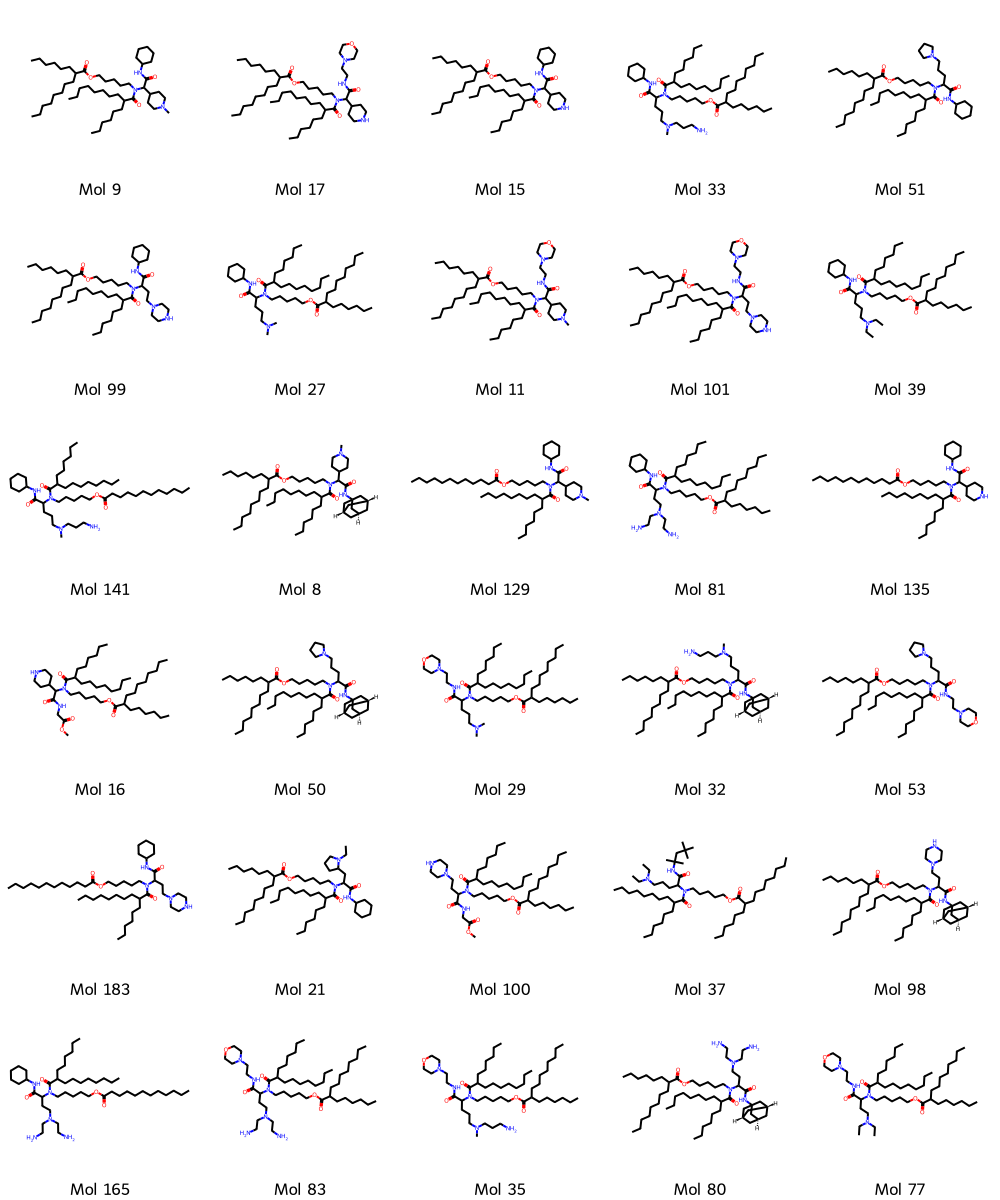

['CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCN(C)CC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCNCC1)C(=O)NCCN1CCOCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCNCC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN(C)CCCN)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN1CCCC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCN1CCNCC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN(C)C)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCN(C)CC1)C(=O)NCCN1CCOCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCN1CCNCC1)C(=O)NCCN1CCOCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN(CC)CC)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC']


In [7]:
# rank the predict_df by predict value
predict_df_sort = predict_df.sort_values(by="predict", ascending=False)
predict_df_sort.to_csv(f"./infer_{description}/4CR_results_sort.csv", index=False)

# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 10 predicted smiles: ")
img = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smi) for smi in predict_df_sort["SMILES"].values[:30]],
    molsPerRow=5,
    legends=[f"Mol {id}" for id in predict_df_sort["SMILES"].index[:30]],
)
display(img)
print(predict_df_sort["SMILES"].values[:10])

Least 10 predicted smiles: 


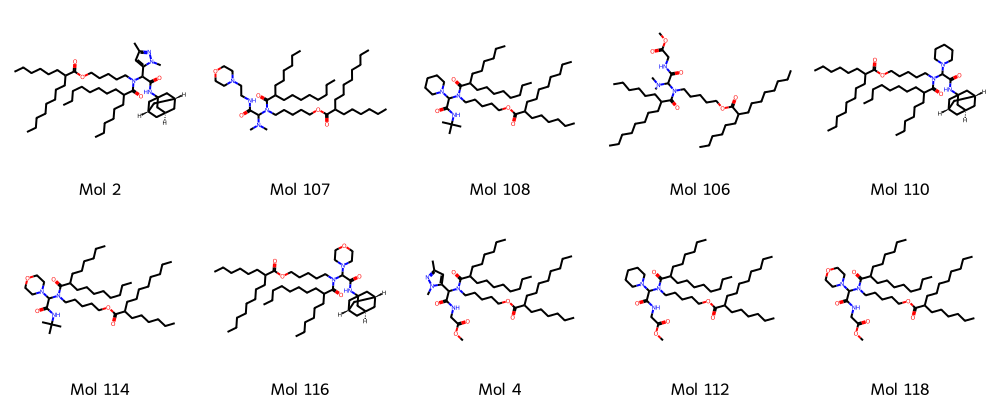

In [8]:
print("Least 10 predicted smiles: ")
img = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smi) for smi in predict_df_sort["SMILES"].values[-10:]],
    molsPerRow=5,
    legends=[f"Mol {id}" for id in predict_df_sort["SMILES"].index[-10:]],
)
display(img)

Top 10 experiment smiles: 


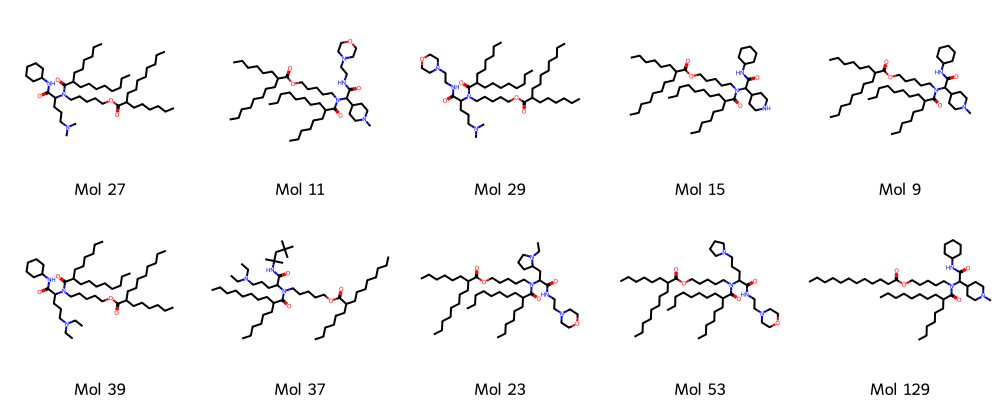

In [9]:
# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 10 experiment smiles: ")
Draw.MolsToGridImage(
    [
        Chem.MolFromSmiles(smi)
        for smi in predict_df.sort_values(by="target", ascending=False)[
            "SMILES"
        ].values[:10]
    ],
    molsPerRow=5,
    legends=[
        f"Mol {id}"
        for id in predict_df.sort_values(by="target", ascending=False)["SMILES"].index[
            :10
        ]
    ],
)

Test again

In [10]:
data_path='./'  # replace to your data path
results_path=f"./infer_{description}"  # replace to your results path
weight_path=f"./{save_dir}/checkpoint_best.pt"  # replace to your ckpt path
# batch_size=64
# task_name='4CR' # data folder name 
# task_num=1
# loss_func='finetune_mse'
# dict_name='dict.txt'
# conf_size=11
# only_polar=0

!cp ../example_data/molecule/$dict_name $data_path
!CUDA_VISIBLE_DEVICES="0" python ../unimol/infer.py --user-dir ../unimol $data_path --task-name $task_name --valid-subset test \
       --results-path $results_path \
       --num-workers 6 --ddp-backend=c10d --batch-size $batch_size \
       --task mol_finetune --loss $loss_func --arch unimol_base \
       --classification-head-name $task_name --num-classes $task_num \
       --dict-name $dict_name --conf-size $conf_size \
       --only-polar $only_polar  \
       --path $weight_path  \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 50 --log-format simple 
       # --encoder-attention-heads 8 \
       # --encoder-embed-dim 768 --encoder-ffn-embed-dim 3072 \

2024-05-10 23:02:36 | INFO | unimol.inference | loading model(s) from ./save_4CR_0510-24/checkpoint_best.pt
2024-05-10 23:02:37 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types


2024-05-10 23:02:40 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='simple', tensorboard_logdir='', seed=1, cpu=False, fp16=True, bf16=False, bf16_sr=False, allreduce_fp32_grad=False, fp16_no_flatten_grads=False, fp16_init_scale=4, fp16_scale_window=256, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir='../unimol', empty_cache_freq=0, all_gather_list_size=16384, suppress_crashes=False, profile=False, ema_decay=-1.0, validate_with_ema=False, loss='finetune_mse', optimizer='adam', lr_scheduler='fixed', task='mol_finetune', num_workers=6, skip_invalid_size_inputs_valid_test=False, batch_size=128, required_batch_size_multiple=8, data_buffer_size=10, train_subset='train', valid_subset='test', validate_interval=1, validate_interval_updates=0, validate_after_updates=0, fixed_validation_seed=None, disable_validation=False, batch_size_valid=128, max_valid_steps=None, curriculum=0, distributed_world_size=1, distributed